In [52]:
import json
import os
import torch
import pandas as pd
from pathlib import Path
import sys
sys.path.insert(1, '../')
from infer_pipeline import inferPipeline
from logger_ import make_logger
from datetime import datetime
from utils.tranform_functions import read_data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# setting logging
now = datetime.now()
logDir = now.strftime("%d_%m-%H_%M")
if not os.path.isdir(logDir):
    os.makedirs(logDir)

logger = make_logger(name = 'get_word_represent', debugMode=True,
                    logFile=os.path.join(logDir, 'get_word_represent.log'), silent=True)
logger.info("logger created.")


# model_path = Path('./output/multi_task_model_9_13050.pt')
# pipe = inferPipeline(model_path, logger)


In [53]:
def get_sum_avg(last_hidden_state, pos_tag_id):
    
    # lhds = 32 128 768 
    # pos tag = 32 128
    
    b_sum_vector = []
    b_avg_vector = []
    
    for index in range(len(pos_tag_id)):
        masked_index = torch.where(pos_tag_id[index] != 0)
        sum_vector_present = torch.sum(last_hidden_state[index][masked_index], 0)
        avg_vector_present = torch.mean(last_hidden_state[index][masked_index], 0)
        
        assert sum_vector_present.shape == avg_vector_present.shape == torch.Size([768])
        
        b_sum_vector.append(sum_vector_present)
        b_avg_vector.append(avg_vector_present)
    return b_sum_vector, b_avg_vector

In [55]:
def get_word_represent(model, dataloader):
    '''Get word presentation from original BioBert model'''
    df = pd.DataFrame()
    model.eval()
    origin_ids = []
    list_sum_vector = []
    list_avg_vector = []
    for batch in dataloader:
        batch = tuple(t.to(device) if isinstance(t, torch.Tensor) else t for t in batch)
        origin_uid, token_id, type_id, mask, label, pos_tag_id, _ = batch
        # origin_uid, tensors['token_id'], tensors['type_id'], tensors['mask'], tensors['label'], tensors['pos_tag_id'], tensors['masked_id']
        origin_ids.append(origin_uid)
        with torch.no_grad():
            outputs_model = model(token_id, type_id, mask)
            last_hidden_states = outputs_model[0]
            sum_vector, avg_vector = get_sum_avg(last_hidden_states, pos_tag_id)
            
            # sum last 4 
            # hidden_states = outputs_model[2]
            # word_embed = torch.stack(hidden_states[-4:]).sum(0)
            # sum_vector, avg_vector = get_sum_avg(word_embed, pos_tag_id)
            
            list_sum_vector.append(sum_vector)
            list_avg_vector.append(avg_vector)
        
    df['uid'] = [item for sublist in origin_ids for item in sublist]
    df['sum_vector'] = [item for sublist in list_sum_vector for item in sublist]
    df['avg_vector'] = [item for sublist in list_avg_vector for item in sublist]
   
    return df    
            

In [56]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from mlm_utils.pertured_dataset import PerturbedDataset
from mlm_utils.transform_func import check_data_dir, get_files
from mlm_utils.metric_func import cosine_sim, cosine_module, ele_wise_sub


def cal_all_files(pipe, dataDir, embDir, wriDir):
    files = get_files(dataDir)
    emb_files = get_files(embDir)
    
    check_data_dir(wriDir, auto_create=True)
    
    for file, emb_file in tqdm(zip(files, emb_files)):
        print("file", file, "emb_file", emb_file)
        df_metric = pd.DataFrame()
    
        pipe.infer(dataDir, file)
        df = get_word_represent(pipe.model, pipe.dataloader)
    
        emb_df = pd.DataFrame(read_data(embDir/emb_file))
       
        # convert tensor to list
        df['sum_vector'] = df['sum_vector'].apply(lambda x: x.tolist())
        
        # calculate Hypothesis 1 and Hypothesis 2 in Task 1.1
        df_metric['uid'] = df['uid']
        df_metric['cos_sim'] = pd.Series(map(cosine_sim, df['sum_vector'], emb_df['sum_vector']))
        df_metric['cos_mo'] = pd.Series(map(cosine_module, df['sum_vector'], emb_df['sum_vector'], df_metric['cos_sim']))
        df_metric['ele_sub_neg'] = pd.Series(map(lambda x, y: ele_wise_sub(x, y, negate=True), df['sum_vector'], emb_df['sum_vector']))
        
        df_metric['cos_dif'] = 1 - np.abs(df_metric['cos_sim'])
        df_metric['cos_mo_dif'] = 1 - np.abs(df_metric['cos_mo'])
        df_metric['ele_sub'] = pd.Series(map(lambda x, y: ele_wise_sub(x, y), df['sum_vector'], emb_df['sum_vector']))
        
        
        # save df to csv 
        df_metric.to_csv(wriDir/f'{file}.csv'.replace('.json', ''), index=False)
        
        print(f'{file} done')
    return df_metric
    

In [57]:
from pathlib import Path
# bertmodel = BertModel.from_pretrained('dmis-lab/biobert-base-cased-v1.2', output_hidden_states =True)
pipe = inferPipeline(logger)

## Calculate difference between word presentation from original model and fine-tuned model

In [58]:

dataDir = Path('./data_mlm/process_folder/mlm_output')
wriDir = Path('/mnt/c/Users/Phat Pham/Documents/THESIS/SRLPredictionEasel/MLM/data_mlm/process_folder/PAS_knowledge')
embDir = Path('./data_mlm/process_folder/word_represent_finetuned_model')
df = cal_all_files(pipe, dataDir, embDir, wriDir)                                 


0it [00:00, ?it/s]

file mlm_abolish_full.json emb_file mlm_abolish_full.json


1it [01:59, 119.30s/it]

mlm_abolish_full.json done
file mlm_alter_full.json emb_file mlm_alter_full.json


In [15]:
df.head()

,uid,cos_sim,cos_mo,ele_sub_neg,cos_dif,cos_mo_dif,ele_sub
0,tensor(0),0.00674,0.00590,-0.75195,0.99326,0.99410,0.75195
1,tensor(0),-0.06479,-0.05743,-0.78418,0.93521,0.94257,0.78418
2,tensor(0),0.02651,0.02541,-2.50342,0.97349,0.97459,2.50342
3,tensor(0),-0.00867,-0.00758,-1.12512,0.99133,0.99242,1.12512
4,tensor(0),-0.09000,-0.07904,-0.75584,0.91000,0.92096,0.75584
5,tensor(0),0.01004,0.00871,-0.73599,0.98996,0.99129,0.73599
6,tensor(0),-0.04758,-0.04168,-0.74757,0.95242,0.95832,0.74757
7,tensor(0),0.02190,0.01973,-1.72962,0.97810,0.98027,1.72962


In [27]:

df_pair_score = pd.read_csv('/mnt/c/Users/Phat Pham/Documents/THESIS/SRLPredictionEasel/MLM/10_07-12_42/all_pair_score.csv')
df_pair_score.shape

(28, 5)

In [48]:
from scipy.stats import spearmanr
correlation_coefficient, p_value = spearmanr(df_pair_score['brier_score'], df['ele_sub'][:28])
print(correlation_coefficient, p_value) 

0.11095397468527728 0.5740575901354124


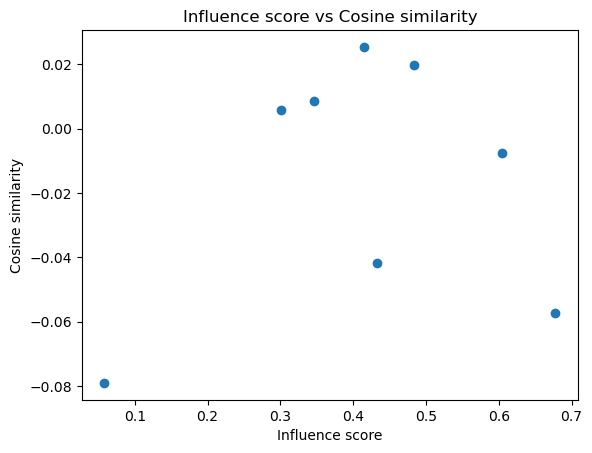

In [21]:
# visualize the correlation
import matplotlib.pyplot as plt
plt.scatter(df_pair_score['influence'], df['cos_mo'][:8])
plt.xlabel('Influence score')
plt.ylabel('Cosine similarity')
plt.title('Influence score vs Cosine similarity')
plt.show()


In [ ]:
# cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
# last_hidden_states = outputs_model[0]
# hidden_states = outputs_model[2]

# # sum of last four layer
# word_embed_5 = torch.stack(hidden_states[-4:]).sum(0)

# # concatenate last four layers
# word_embed_6 = torch.cat([hidden_states[i] for i in [-1,-2,-3,-4]], dim=-1)

# return last_hidden_states, word_embed_5, word_embed_6


# calculate cosine similarity

In [ ]:
from transformers import BertConfig, BertModel, BertTokenizer

data = read_data('/mnt/c/Users/Phat Pham/Documents/THESIS/SRL-for-BioBERT/data/coNLL_tsv/bert-base-uncased_prepared_data/ner_conll_testa_abolish.json')

print("data shape: ", len(data))  # 280
tokens_id = data[0]['token_id']
segments_id = data[0]['type_id']


# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([tokens_id])
segments_tensors = torch.tensor([segments_id])

# Load pre-trained model (weights)
model = BertModel.from_pretrained('dmis-lab/biobert-base-cased-v1.2',
                                output_hidden_states = True # Whether the model returns all hidden-states.
                                )
# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)
    print("outputs: ", len(outputs)) # 2
    hidden_states = outputs[2]
    last_hidden_states = outputs[0]


print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")  #13
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i])) #1
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i])) #50
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))     # each token 768 features


# `hidden_states` is a Python list.
print('      Type of hidden_states: ', type(hidden_states)) # <class 'tuple'>

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', hidden_states[0].size()) # torch.Size([1, 50, 768])


# `token_vecs` is a tensor with shape [50 x 768]
token_vecs = hidden_states[-2][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)
print ("Our final sentence embedding vector of shape:", sentence_embedding.size()) # torch.Size([768])

data shape:  280
outputs:  3
Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 50
Number of hidden units: 768
      Type of hidden_states:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 50, 768])
Our final sentence embedding vector of shape: torch.Size([768])


In [ ]:
import pickle
with open('models/outputs.pkl', 'rb') as f:
    token_vecs_cat = pickle.load(f)

print("token_vecs_cat: ", len(token_vecs_cat)) # 50
print(token_vecs_cat['uid']) # (3072,)


token_vecs_cat:  2
['22110', '22111', '22112', '22113', '22114', '22115', '22116', '22117', '22118', '22119', '22120', '22121', '22122', '22123', '22124', '22125', '22126', '22127', '22128', '22129', '22130', '22131', '22132', '22133', '22134', '22135', '22136', '22137', '22138', '22139', '22140', '22141']


# read pickle file for test word present in the model

In [ ]:
import pandas as pd
import torch
import pickle

data_file = './vecs_ner_conll_testa_abolish.pkl'
with open(data_file, 'rb') as f:
    data = pickle.load(f)

data['vec']
df = pd.DataFrame(data['vec'])

In [ ]:
df.shape

(50, 3072)